## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate

import subprocess
import time
import glob
import re
from IPython.display import clear_output
import warnings
from collections import defaultdict # modified version of dictionary

plt.rcParams.update({'font.size': 16})
warnings.filterwarnings(action = 'ignore', message = 'Mean of empty slice')

## Functions

In [220]:
# function to compute F_i^* \forall i
def F_teo(beta, chi):

    F = np.ones(len(beta))

    if (chi == 0): # to avoid divergences
        chi = 1e-11

    for it in range(10000):
        N = beta.sum() / (1 + chi * F.sum())
        F = np.minimum(1, beta / (N * chi))

    return F, N

# function to compute F_i^* \forall i and chi!
def F_teo_slope(beta, slope):

    F = np.ones(len(beta))
    N = 1
    
    for it in range(10000):
        chi = 1 / (N * slope)
        N = beta.sum() / (1 + chi * F.sum())
        F = np.minimum(1, beta / (N * chi))

    return F, N, chi

# function to fit the effective chi from the data
def effective_chi(temp):
    beta = temp[:, 0].mean(axis = 0)
    F = temp[:, 3].mean(axis = 0)

    for j in range(R):
        if (F[j] > 0.95):
            pos = j + 1
            break

    if (pos == 1):
        chi_eff = 0

    else:
        # we add zero in the first position
        beta = np.insert(beta, 0, 0)
        F = np.insert(F, 0, 0)

        slope = np.polyfit(beta[:pos], F[:pos], 1)[0]
        _, _, chi_eff = F_teo_slope(beta, slope)
        
    return chi_eff

## Set parameters and run simulations

In [3]:
# --------------- parameters --------------- #
# we have R resources and an ancestral population consisting
# of n_start individuals and we study them for n_gen generations
R = 6
n_start = 1e7
n_gen = 1e5 # number of generations (PER R = 9, 1.5E5), (PER R = 6, 1E5)

dt_gen = n_gen / 10 # number of generations between two sequencings
D = 1e4 # depth of sequencing

n_simulations = 50 # number of simulations with the same parameters

fast = 0 # if we want faster simulations we have to give up "checkpoints"
         # (sequencing every dt_gen generations) (fast = 1, slow = 0)
generalist = 1 # specialist = 0, generalist = 1, complete pool = 2
random_selection = 1 # should the selection step be stochastic or deterministic? (stochastic = 1, deterministic = 0)

In [ ]:
clean = False # do we want to delete the existing files?
CHI = [1, 2, 3, 4, 10, 20] # cost per resource (death rate)

# number of mutations in the population per generation
nu_y = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
nu_alpha = [0, 0.001, 0.1, 1, 10, 100] # done!
#nu_alpha = [1000] # done for R = 6, to do for R = 9

EPS = [1e-2] # small perturbations around beta
S = [1e-3, 1e-2, 1e-1, 1, 10] # fitness increment in mutation

if (clean):
    subprocess.call('./clean.sh', shell = True)
else: # clean == False
    # we check whether there are files that already exist or not!
    # this way we avoid awkward overwriting of important and time-costing files!
    already_exists = False
    for (i, eps) in enumerate(EPS):
        for (j, s) in enumerate(S):
            for(k, NU_Y) in enumerate(nu_y):
                for(l, NU_alpha) in enumerate(nu_alpha):
                        for chi in CHI:
                            for filename in glob.glob("./Data/run_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, n_start, n_gen, generalist, random_selection, eps, s, NU_Y, NU_alpha, chi)):
                                already_exists = True

    if already_exists == True:
        stop = input('One or more files already exist! Do you want to STOP the execution? (y / n): ')
        if stop != 'n' and stop != 'N' and stop != 'no' and stop != 'No' and stop != 'NO' and stop != 'nO':
            raise SystemExit('The user decided to stop')

# we compile the file
subprocess.call('make clean', shell = True)
subprocess.call('make', shell = True)
        
t_actual_start = time.time()

for (i, eps) in enumerate(EPS):
    for (j, s) in enumerate(S):
        for(k, NU_Y) in enumerate(nu_y):
            for(l, NU_alpha) in enumerate(nu_alpha):
                    clear_output(wait = True)
                    curr = i * len(S) * len(nu_y) * len(nu_alpha) + j * len(nu_y) * len(nu_alpha) + k * len(nu_alpha) + l + 1
                    tot = len(EPS) * len(S) * len(nu_y) * len(nu_alpha)
                    print(curr, '/', tot, ': eps = {}, s = {}, NU_Y = {}, NU_alpha = {}'.format(eps, s, NU_Y, NU_alpha))
                    
                    for (h, chi) in enumerate(CHI):
                        print('Running: chi =', chi)

                        # we compute a seed for the random number generator
                        seed = i * len(S) * len(nu_y) * len(nu_alpha) * len(CHI) + j * len(nu_y) * len(nu_alpha) * len(CHI) + k * len(nu_alpha) * len(CHI) + l * len(CHI) + h
                        
                        # let's write the data in one string, which we will pass to the command line arguments
                        data = str(R) + ' ' + str(n_start) + ' ' + str(n_gen) + ' ' + str(dt_gen) + ' ' + str(D) + ' ' + str(NU_Y) + ' ' + str(NU_alpha) + ' ' + str(n_simulations)+ ' ' + str(fast) + ' ' + str(generalist) + ' ' + str(random_selection) + ' ' + str(seed) + ' ' + str(chi) + ' ' + str(eps) + ' ' + str(s)
                        
                        tstart = time.time()
                        subprocess.call('./main.exe ' + data, shell = True)
                        print('Time to run the code =', round((time.time() - tstart) / 60), 'min')

print('Total time =', round((time.time() - t_actual_start) / 60), 'min')

## Plots

In [4]:
# plot with these parameters
R = 6
CHI = [1, 2, 3, 4, 10, 20]
eps = 1e-2
s = 1e-2

NU_alpha = 1
NU_Y = 1

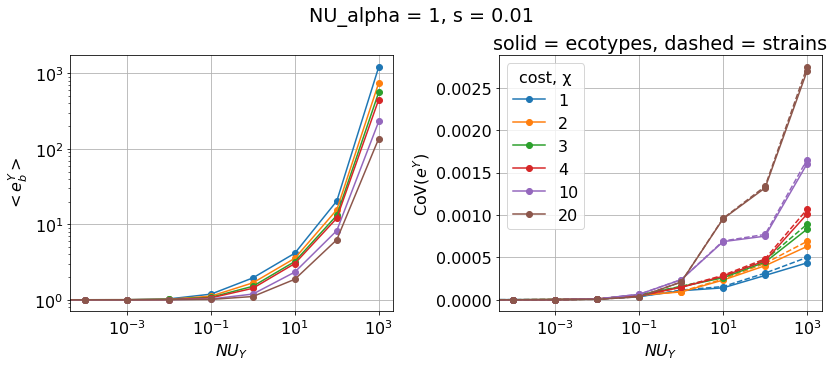

In [45]:
#for filename in glob.glob("./Data/run_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, n_start, n_gen, generalist, random_selection, eps, s, NU_Y, NU_alpha, chi)):

fig, ax = plt.subplots(figsize = (12, 5), nrows = 1, ncols = 2)

for (i, chi) in enumerate(CHI):
    FIT = []
    COV_eco = []
    COV_strain = []
    UY = []

    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))
        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        NU_Y_file = float(numbers[7])

        # weighted mean of the coefficients of variation (of the fitness) over the different ecotypes and the simulations
        mean_fit = temp[:,4] * temp[:,7] / np.nansum(temp[:,7], axis = 1).reshape((n_simulations, 1)) # <e^Y>_b * m_b / \sum_b' m_b'
        mean_fit = np.nansum(mean_fit, axis = 1) # \sum_b <e^Y>_b * m_b / \sum_b' m_b' (average over the ecotypes)
        mean_fit = np.mean(mean_fit) # average over the simulations

        FIT.append(mean_fit)
        COV_eco.append(np.nanmean(temp[:,11]))
        COV_strain.append(np.nanmean(temp[:,12]))
        UY.append(NU_Y_file)

    _, FIT = list(zip(*sorted(zip(UY, FIT)))) # sort the two list based on NU_Y
    _, COV_eco = list(zip(*sorted(zip(UY, COV_eco)))) # sort the two list based on NU_Y
    UY, COV_strain = list(zip(*sorted(zip(UY, COV_strain)))) # sort the two list based on NU_Y
    
    ax[0].plot(UY, FIT, 'o-C' + str(i), label = chi)
    ax[1].plot(UY, COV_eco, 'o-C' + str(i), label = chi)
    ax[1].plot(UY, COV_strain, 'o--C' + str(i))

fig.suptitle('NU_alpha = {}, s = {}'.format(NU_alpha, s), y = 1.03)

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_xlabel(r'$NU_Y$')
ax[0].set_ylabel(r'$<e^Y_b>$')
ax[0].grid()

ax[1].set_xscale('log')
ax[1].set_title('solid = ecotypes, dashed = strains')
ax[1].set_xlabel(r'$NU_Y$')
ax[1].set_ylabel(r'CoV($e^Y$)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(), title = 'cost, χ', loc = 0)

ax[1].grid()
plt.tight_layout()
plt.show()

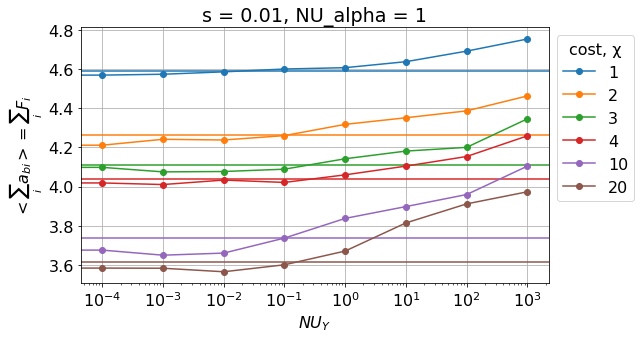

In [46]:
fig = plt.figure(figsize = (8, 5))

for (i, chi) in enumerate(CHI):
    GENSIZE = []
    UY = []

    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))
        
        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        NU_Y_file = float(numbers[7])
        
        mean_gen_size = temp[:,6] * temp[:,7] / np.nansum(temp[:,7], axis = 1).reshape((n_simulations, 1)) # gen_size_b * m_b / \sum_b' m_b'
        mean_gen_size = np.nansum(mean_gen_size, axis = 1) # \sum_b gen_size_b * m_b / \sum_b' m_b' (average over the ecotypes)
        mean_gen_size = np.mean(mean_gen_size) # average over the simulations
        UY.append(NU_Y_file)
        GENSIZE.append(mean_gen_size)
        
        if NU_Y_file == 0:
            beta = temp[:, 0].mean(axis = 0)
            _, N = F_teo(beta, chi)
            beta_teo = np.linspace(min(beta), max(beta), R)
            F_theo = np.minimum(1, beta_teo / (N * chi + 1e-11))
            plt.axhline(F_theo.sum(), color = 'C' + str(i))
        
    UY, GENSIZE = list(zip(*sorted(zip(UY, GENSIZE)))) # sort the two list based on NU_Y 
    plt.plot(UY, GENSIZE, 'o-C' + str(i), label = chi)

plt.xscale('log')
plt.title('s = {}, NU_alpha = {}'.format(s, NU_alpha))
plt.xlabel(r'$NU_Y$')
plt.ylabel(r'$<\sum_i {a_{b i}}> = \sum_i F_i$')
plt.grid(True)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'cost, χ', loc = 0, bbox_to_anchor = (1, 1))

plt.show()

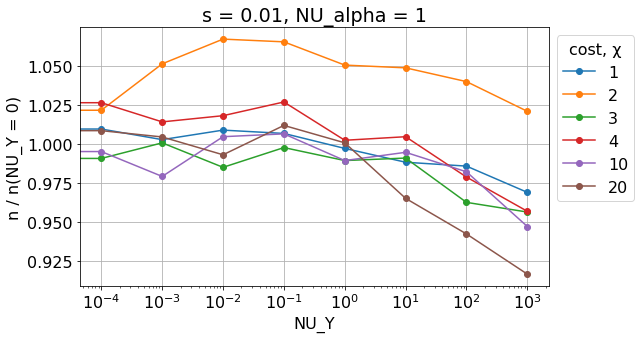

In [47]:
fig = plt.figure(figsize = (8, 5))

for (i, chi) in enumerate(CHI):
    
    UY = []
    N = []

    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        NU_Y_file = float(numbers[7])
        UY.append(NU_Y_file)

        n = temp[:,7]
        
        N.append(np.nansum(n, axis = 1).mean())

    UY, N = list(zip(*sorted(zip(UY, N)))) # sort the two list based on NU_Y
    plt.plot(UY, N / N[0], 'o-C' + str(i), label = chi)


plt.xscale('log')
plt.title('s = {}, NU_alpha = {}'.format(s, NU_alpha))
plt.xlabel('NU_Y')
plt.ylabel('n / n(NU_Y = 0)')
plt.grid(True)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'cost, χ', loc = 0, bbox_to_anchor = (1, 1))

plt.show()

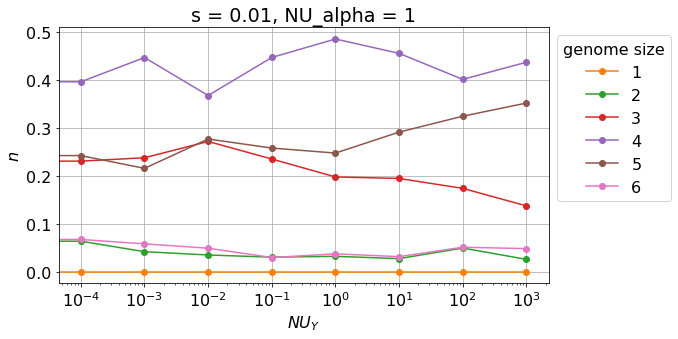

In [48]:
fig = plt.figure(figsize = (8, 5))

for (i, chi) in enumerate(CHI):

    eeyy = np.zeros(9)
    count = 0
    for k in range(R):
        
        UY = []
        N = []
        
        for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
            temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
            temp = np.array(np.split(temp, n_simulations))

            numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
            NU_Y_file = float(numbers[7])
            UY.append(NU_Y_file)

            eY = temp[:,4] / np.nanmean(temp[:,9], axis = 1).reshape((n_simulations, 1))
            gen_size = temp[:,6]
            n = temp[:,7] / np.nansum(temp[:,7], axis = 1).reshape((n_simulations, 1))# * gen_size

            #p = np.where(gen_size == k + 1)
            n_masked = np.where(gen_size == k + 1, n, np.nan)
            N.append(np.nansum(n_masked, axis = 1).mean())

        UY, N = list(zip(*sorted(zip(UY, N)))) # sort the two list based on NU_Y
        
        if chi == 4:
            if(np.isnan(np.array(N)).sum() == 0):
                eeyy += np.array(N)
                count += 1

            plt.plot(UY, N, 'o-C' + str(k + 1), label = k + 1)
        
    #eeyy /= count
    #if chi == 4:
    #    plt.plot(UY, eeyy, lw = 3, label = 'mean')

plt.xscale('log')
plt.title('s = {}, NU_alpha = {}'.format(s, NU_alpha))
plt.xlabel(r'$NU_Y$')
plt.ylabel(r'$n$')
plt.grid(True)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'genome size', loc = 0, bbox_to_anchor = (1, 1))

plt.show()

<ipython-input-49-9928db0c3c49>:29: RuntimeWarning: invalid value encountered in true_divide
  eY_new = np.nansum(eY_new * np.nansum(n_masked, axis = 1) / np.nansum(n_masked))


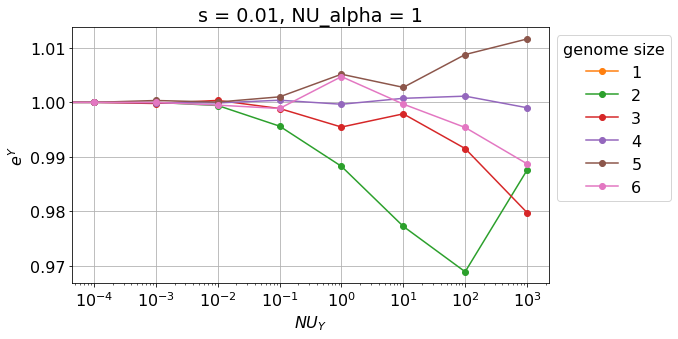

In [49]:
fig = plt.figure(figsize = (8, 5))

for (i, chi) in enumerate(CHI):
    NTOT = defaultdict(int)
    EYs = defaultdict(list)

    for k in range(R):
        #print('gen_size =', k + 1)

        EY = []
        UY = []
        
        for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
            temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
            temp = np.array(np.split(temp, n_simulations))

            numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
            NU_Y_file = float(numbers[7])
            UY.append(NU_Y_file)

            eY = temp[:,4] / np.nanmean(temp[:,9], axis = 1).reshape((n_simulations, 1))
            gen_size = temp[:,6]
            n = temp[:,7]
            
            eY_masked = np.where(gen_size == k + 1, eY, np.nan)
            n_masked  = np.where(gen_size == k + 1, n, np.nan)
            
            eY_new = np.nansum(eY_masked * n_masked / np.nansum(n_masked, axis = 1).reshape((n_simulations, 1)), axis = 1)
            eY_new = np.nansum(eY_new * np.nansum(n_masked, axis = 1) / np.nansum(n_masked))
            
            if (eY_new == 0):
                eY_new = np.nan

            EY.append(eY_new)
            
            EYs[NU_Y_file].append(eY_new * np.nansum(n_masked))
            NTOT[NU_Y_file] += np.nansum(n_masked)

            hash_vals = temp[:,8]
            hash_vals = np.where(gen_size == k + 1, hash_vals, np.nan)
            
            # find unique hashing values, AKA uniques ecotypes with given genome size
            uniques = np.unique(hash_vals, axis = 0)
            len_uniques = np.mean(np.sum(~np.isnan(uniques), axis = 1))
            #print('For NU_Y =', NU_Y_file, 'there are', len_uniques, 'ecotypes in average')
            
            
        UY, EY = list(zip(*sorted(zip(UY, EY)))) # sort the two list based on NU_Y
        #print()
        if chi == 4:
            plt.plot(UY, EY, 'o-C' + str(k + 1), label = k + 1)
            
plt.xscale('log')
plt.title('s = {}, NU_alpha = {}'.format(s, NU_alpha))
plt.xlabel(r'$NU_Y$')
plt.ylabel(r'$e^Y$')
plt.grid(True)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'genome size', loc = 0, bbox_to_anchor = (1, 1))

plt.show()

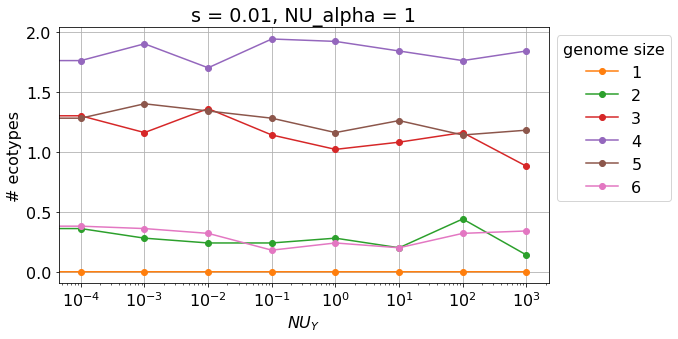

In [50]:
fig = plt.figure(figsize = (8, 5))

for (i, chi) in enumerate(CHI):
    NTOT = defaultdict(int)
    EYs = defaultdict(list)

    for k in range(R):

        EY = []
        UY = []
        
        for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
            temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
            temp = np.array(np.split(temp, n_simulations))

            numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
            NU_Y_file = float(numbers[7])
            UY.append(NU_Y_file)

            gen_size = temp[:,6]
            hash_vals = temp[:,8]
            
            hash_vals = np.where(gen_size == k + 1, hash_vals, np.nan)
            
            # find unique hashing values, AKA uniques ecotypes with given genome size
            uniques = np.unique(hash_vals, axis = 0)
            len_uniques = np.mean(np.sum(~np.isnan(uniques), axis = 1))
            EY.append(len_uniques)
            
        UY, EY = list(zip(*sorted(zip(UY, EY)))) # sort the two list based on NU_Y
        if chi == 4:
            plt.plot(UY, EY, 'o-C' + str(k + 1), label = k + 1)
            
plt.xscale('log')
plt.title('s = {}, NU_alpha = {}'.format(s, NU_alpha))
plt.xlabel(r'$NU_Y$')
plt.ylabel('# ecotypes')
plt.grid(True)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'genome size', loc = 0, bbox_to_anchor = (1, 1))

plt.show()

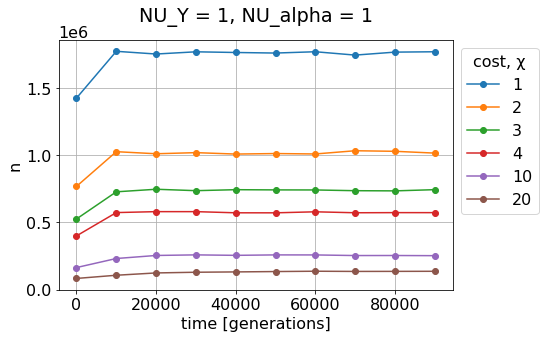

In [51]:
fig = plt.figure(figsize = (8,5))

for (i, chi) in enumerate(CHI):

    for filename in glob.glob("./Data/n_gen_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_Y, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations)) # we divide the file in the simulations
        temp = np.array(np.split(temp, n_gen / dt_gen, axis = 1)) # we divide the file in the timesteps
        
        n = np.nansum(temp[:,:,7], axis = 2) # sum of the populations of the ecotypes
        n = n.mean(axis = 1) # we average over the different simulations
        #if chi == 1:
        plt.plot(np.arange(n_gen/dt_gen) * dt_gen, n, 'o-C'+str(i), label = chi)

plt.title('NU_Y = {}, NU_alpha = {}'.format(NU_Y, NU_alpha), y = 1.05)
plt.xlabel('time [generations]')
plt.ylabel('n')


plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'cost, χ', bbox_to_anchor = (1, 1), loc = 0)

plt.tight_layout()
plt.show()

/home/abi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/abi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/abi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/abi/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


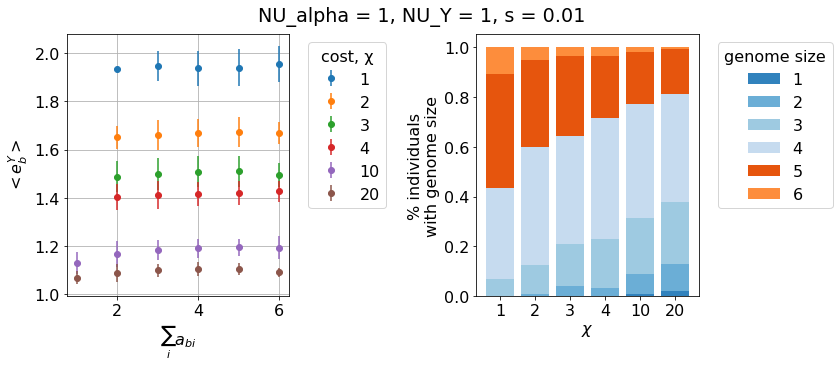

In [52]:
fig, ax = plt.subplots(figsize=(12, 5), nrows = 1, ncols = 2)

pops = np.zeros((R, len(CHI)))

for (i, chi) in enumerate(CHI):
    legend_done = False
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_Y, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))
        
        fitness = temp[:,4]
        gen_size = temp[:,6]
        pop = temp[:,7] / np.nansum(temp[:,7], axis = 1).reshape((n_simulations, 1)) # percentage of populations
        somma = 0
        for k in range(R):
            p = np.where(gen_size == k + 1)
            pops[k][i] = pop[p].sum() / n_simulations
            
            if(legend_done == False):
                ax[0].errorbar(gen_size[p].mean(), fitness[p].mean(), yerr = fitness[p].std(), color = 'C' + str(i), fmt='o', label = chi)            
                legend_done = True
            else:
                ax[0].errorbar(gen_size[p].mean(), fitness[p].mean(), yerr = fitness[p].std(), color = 'C' + str(i), fmt='o')            

                
my_cmap = plt.get_cmap("tab20c")        
bottom = np.zeros(len(CHI))
for k in range(R):
    ax[1].bar([str(x) for x in CHI], pops[k], bottom = bottom, label = k + 1, color = my_cmap.colors[k])
    bottom += pops[k]
    
fig.suptitle('NU_alpha = {}, NU_Y = {}, s = {}'.format(NU_alpha, NU_Y, s), y = 1.03)

ax[0].set_xlabel(r'$\sum_i {a_{b i}}$')
ax[0].set_ylabel(r'$<e^Y_b>$')
ax[0].grid()
ax[0].legend(loc = 0, bbox_to_anchor = (1.05, 1), title = 'cost, χ')

ax[1].set_ylabel('% individuals\nwith genome size')
ax[1].set_xlabel(r'$\chi$')
ax[1].legend(loc = 0, bbox_to_anchor = (1.05, 1), title = 'genome size')

plt.tight_layout()
plt.show()

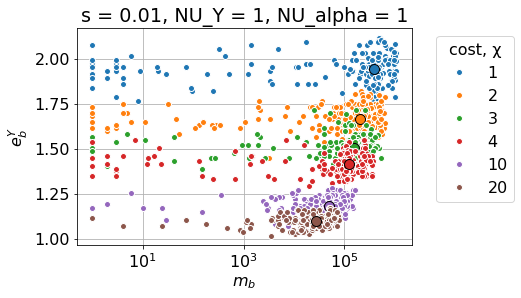

In [53]:
for (i, chi) in enumerate(CHI):

    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_Y, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        x = temp[:,7].flatten()
        y = temp[:,4].flatten()

        plt.plot(x, y, 'oC' + str(i), markeredgecolor = 'w', label = chi)
        plt.plot(np.nanmean(x), np.nanmean(y), 'oC' + str(i), markersize = 10, markeredgecolor = 'k')
        
plt.title('s = {}, NU_Y = {}, NU_alpha = {}'.format(s, NU_Y, NU_alpha))

plt.xlabel(r'$m_b$')
plt.ylabel(r'$e^Y_b$')
plt.xscale('log')
plt.grid()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'cost, χ', loc = 0, bbox_to_anchor = (1.05, 1))

plt.show()

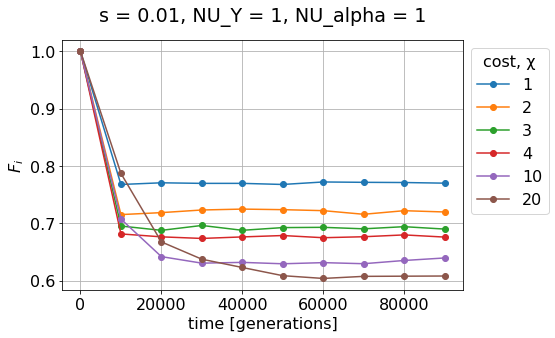

In [54]:
fig = plt.figure(figsize = (8,5))

for (i, chi) in enumerate(CHI):
    for filename in glob.glob("./Data/n_gen_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_Y, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations)) # we divide the file in the simulations
        temp = np.array(np.split(temp, n_gen / dt_gen, axis = 1)) # we divide the file in the timesteps
        
        F = np.nanmean(temp[:,:,3], axis = 2) # mean of the fitnesses of the ecotypes
        F = F.mean(axis = 1) # we average over the different simulations
        
        plt.plot(np.arange(n_gen/dt_gen) * dt_gen, F, 'o-C'+str(i), label = chi)

plt.title('s = {}, NU_Y = {}, NU_alpha = {}'.format(s, NU_Y, NU_alpha), y = 1.05)
plt.xlabel('time [generations]')
plt.ylabel(r'$F_i$')


plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title = 'cost, χ', bbox_to_anchor = (1, 1), loc = 0)

plt.tight_layout()
plt.show()

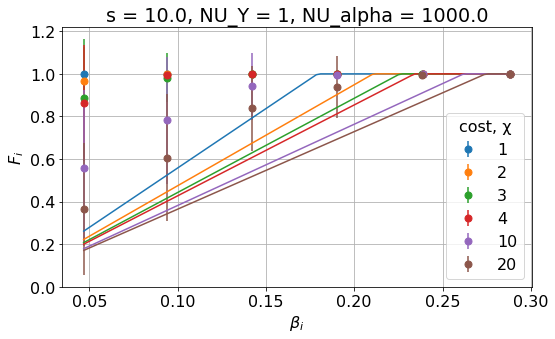

In [195]:
fig = plt.figure(figsize = (8, 5))
for (i, chi) in enumerate(CHI):
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_Y, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))
        #for j in range(n_simulations):
        #    plt.plot(temp[j][0], temp[j][3], 'oC' + str(i), markersize = 4, alpha = 0.1)

        # plot the computational result
        beta = temp[:, 0].mean(axis = 0)
        F = temp[:, 3].mean(axis = 0)
                                
        plt.errorbar(beta, F, yerr = temp[:, 3].std(axis = 0), fmt = 'o', color = 'C' + str(i), markersize = 7, label = chi)
        
        # compute and plot the analytical result
        _, N = F_teo(beta, chi)
        beta_teo = np.linspace(min(beta), max(beta), 100)
        F_theo = np.minimum(1, beta_teo / (N * chi + 1e-11))
        plt.plot(beta_teo, F_theo, 'C'+ str(i))
        #plt.axvline(N * chi, color='C' + str(i))
        
        
plt.title('s = {}, NU_Y = {}, NU_alpha = {}'.format(s, NU_Y, NU_alpha))
plt.xlabel(r'$\beta_i$')
plt.ylabel(r'$F_i$')
plt.grid(True)
plt.tight_layout()
plt.legend(title = 'cost, χ', loc = 0)
#plt.savefig('./Data/Images/F_i_{}_{}_{}.png'.format(s, NU_Y, NU_alpha))
plt.show()

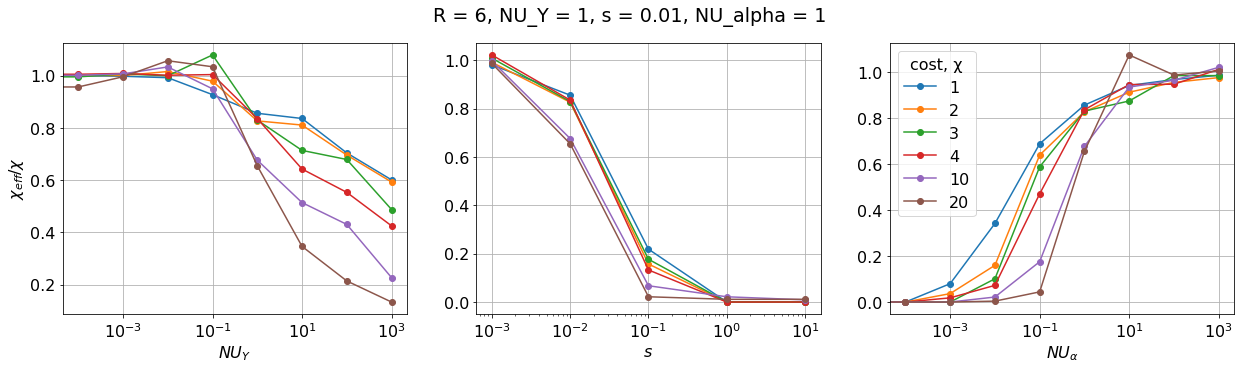

In [5]:
# appo
#NU_Y = 1
#NU_alpha = 1
#s = 10

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (21, 5))
fig.suptitle('R = {}, NU_Y = {}, s = {}, NU_alpha = {}'.format(R, NU_Y, s, NU_alpha))

for (i, chi) in enumerate(CHI):

    CHI_EFF = []
    UY = []
    
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        chi_eff = effective_chi(temp)
        
        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        NU_Y_file = float(numbers[7])
        
        CHI_EFF.append(chi_eff / chi)
        UY.append(NU_Y_file)
            
    UY, CHI_EFF = list(zip(*sorted(zip(UY, CHI_EFF)))) # sort the two list based on U_Y
    ax[0].plot(UY, CHI_EFF, 'o-', label = chi)

ax[0].set_xscale('log')
ax[0].set_xlabel(r'$NU_Y$')
ax[0].set_ylabel(r'$\chi_{eff} / \chi$')
ax[0].grid()

for (i, chi) in enumerate(CHI):

    CHI_EFF = []
    S = []
    
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_*_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, NU_Y, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        chi_eff = effective_chi(temp)
        
        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        s_file = float(numbers[6])
        
        CHI_EFF.append(chi_eff / chi)
        S.append(s_file)
            
    S, CHI_EFF = list(zip(*sorted(zip(S, CHI_EFF)))) # sort the two list based on U_Y
    ax[1].plot(S, CHI_EFF, 'o-', label = chi)

ax[1].set_xscale('log')
ax[1].set_xlabel(r'$s$')
ax[1].grid()

for (i, chi) in enumerate(CHI):

    CHI_EFF = []
    NUALPHA = []
    
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_*_{:0.1e}.txt".format(R, eps, s, NU_Y, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        chi_eff = effective_chi(temp)

        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        NU_alpha_file = float(numbers[8])
        
        CHI_EFF.append(chi_eff / chi)
        NUALPHA.append(NU_alpha_file)
            
    NUALPHA, CHI_EFF = list(zip(*sorted(zip(NUALPHA, CHI_EFF)))) # sort the two list based on U_Y
    ax[2].plot(NUALPHA, CHI_EFF, 'o-', label = chi)

ax[2].set_xscale('log')
ax[2].set_xlabel(r'$NU_\alpha$')
ax[2].grid()
ax[2].legend(title = 'cost, χ', loc = 0)

plt.show()

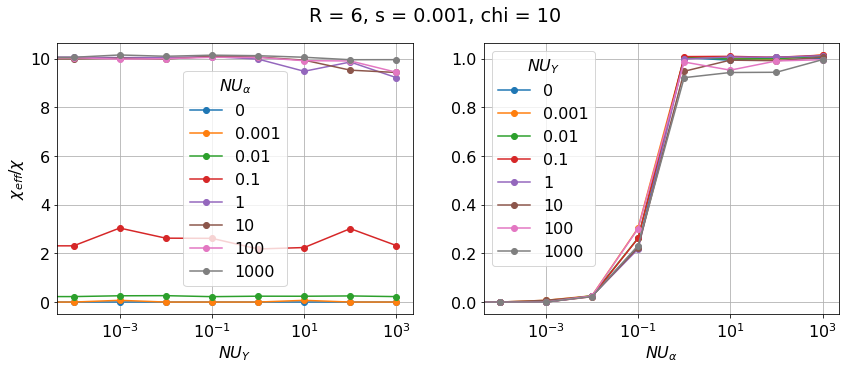

In [141]:
chi = 10
nu_alpha = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
nu_y = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))
fig.suptitle('R = {}, s = {}, chi = {}'.format(R, s, chi))

for NU_alpha in nu_alpha: 
    
        CHI_EFF = []
        UY = []

        for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
            temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
            temp = np.array(np.split(temp, n_simulations))

            chi_eff = effective_chi(temp)

            numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
            NU_Y_file = float(numbers[7])

            CHI_EFF.append(chi_eff)# / chi)
            UY.append(NU_Y_file)

        UY, CHI_EFF = list(zip(*sorted(zip(UY, CHI_EFF)))) # sort the two list based on U_Y
        ax[0].plot(UY, CHI_EFF, 'o-', label = NU_alpha)

ax[0].set_xscale('log')
ax[0].set_xlabel(r'$NU_Y$')
ax[0].set_ylabel(r'$\chi_{eff} / \chi$')
ax[0].grid()
ax[0].legend(title = r'$NU_\alpha$', loc = 0)


for NU_Y in nu_y: 
    
        CHI_EFF = []
        UALPHA = []

        for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_*_{:0.1e}.txt".format(R, eps, s, NU_Y, chi)):

            temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
            temp = np.array(np.split(temp, n_simulations))

            chi_eff = effective_chi(temp)

            numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
            NU_alpha_file = float(numbers[8])

            CHI_EFF.append(chi_eff / chi)
            UALPHA.append(NU_alpha_file)

        UALPHA, CHI_EFF = list(zip(*sorted(zip(UALPHA, CHI_EFF)))) # sort the two list based on U_Y
        ax[1].plot(UALPHA, CHI_EFF, 'o-', label = NU_Y)

ax[1].set_xscale('log')
ax[1].set_xlabel(r'$NU_\alpha$')
ax[1].grid()
ax[1].legend(title = r'$NU_Y$', loc = 0)

plt.show()

plt.show()

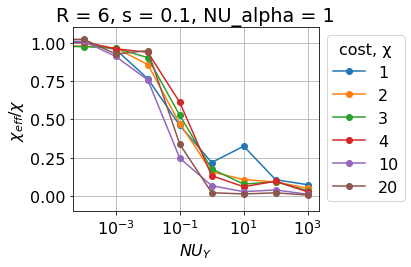

In [223]:
s = 1e-1
NU_alpha = 1
for (i, chi) in enumerate(CHI):

    CHI_EFF = []
    UY = []
    
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        chi_eff = effective_chi(temp)
        
        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        NU_Y_file = float(numbers[7])
        
        CHI_EFF.append(chi_eff / chi)
        UY.append(NU_Y_file)
            
    UY, CHI_EFF = list(zip(*sorted(zip(UY, CHI_EFF)))) # sort the two list based on U_Y
    plt.plot(UY, CHI_EFF, 'o-', label = chi)

plt.ylim(-0.1, 1.1)
plt.xscale('log')
plt.title('R = {}, s = {}, NU_alpha = {}'.format(R, s, NU_alpha))
plt.xlabel(r'$NU_Y$')
plt.ylabel(r'$\chi_{eff} / \chi$')
plt.grid()
plt.legend(title = 'cost, χ', bbox_to_anchor = (1,1), loc = 2)
plt.tight_layout()
#plt.savefig('/home/abi/Scaricati/Prova/Per_gif_NU_Y_{:02d}.png'.format(count))

plt.show()

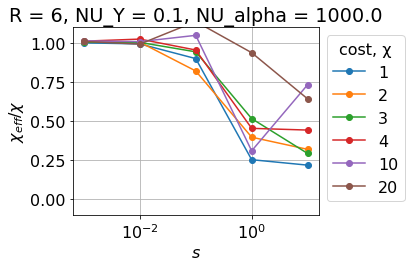

In [111]:
NU_alpha = 1e3
NU_Y = 0.1

for (i, chi) in enumerate(CHI):

    CHI_EFF = []
    S = []
    
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_*_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, NU_Y, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        chi_eff = effective_chi(temp)
        
        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        s_file = float(numbers[6])
        
        CHI_EFF.append(chi_eff / chi)
        S.append(s_file)
            
    S, CHI_EFF = list(zip(*sorted(zip(S, CHI_EFF)))) # sort the two list based on U_Y
    plt.plot(S, CHI_EFF, 'o-', label = chi)

plt.ylim(-0.1, 1.1)
plt.xscale('log')
plt.title('R = {}, NU_Y = {}, NU_alpha = {}'.format(R, NU_Y, NU_alpha))
plt.xlabel(r'$s$')
plt.ylabel(r'$\chi_{eff} / \chi$')
plt.grid()
plt.legend(title = 'cost, χ', bbox_to_anchor = (1,1), loc = 2)

plt.tight_layout()
#plt.savefig('/home/abi/Scaricati/Prova/Per_gif_s_{:02d}.png'.format(count))

plt.show()

Forse, per $\chi = 1$, vale:
$$\chi = \left(e^{-\frac{\left(NU_\alpha-b\cdot\ln\left(100\right)\right)}{b}}+1\right)^{-1}$$

dove $b$ dipende da $NU_Y$ e $s$ in maniera crescente (se cresce $NU_Y$ (o $s$), cresce anche $b$).

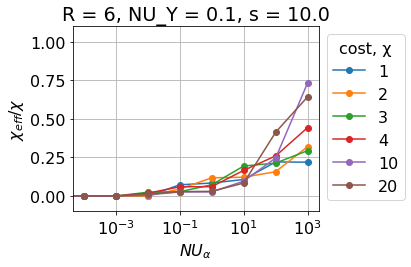

In [177]:
for (i, chi) in enumerate(CHI):

    CHI_EFF = []
    NUALPHA = []
    
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_*_{:0.1e}.txt".format(R, eps, s, NU_Y, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        chi_eff = effective_chi(temp)

        numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
        NU_alpha_file = float(numbers[8])
        
        CHI_EFF.append(chi_eff / chi)
        NUALPHA.append(NU_alpha_file)
            
    NUALPHA, CHI_EFF = list(zip(*sorted(zip(NUALPHA, CHI_EFF)))) # sort the two list based on U_Y
    plt.plot(NUALPHA, CHI_EFF, 'o-', label = chi)

plt.ylim(-0.1, 1.1)
plt.xscale('log')
plt.title('R = {}, NU_Y = {}, s = {}'.format(R, NU_Y, s))
plt.xlabel(r'$NU_\alpha$')
plt.ylabel(r'$\chi_{eff} / \chi$')
plt.grid()
plt.legend(title = 'cost, χ', bbox_to_anchor = (1,1), loc = 2)

plt.tight_layout()
#plt.savefig('/home/abi/Scaricati/Prova/Per_gif_s_{}.png'.format(count))

plt.show()

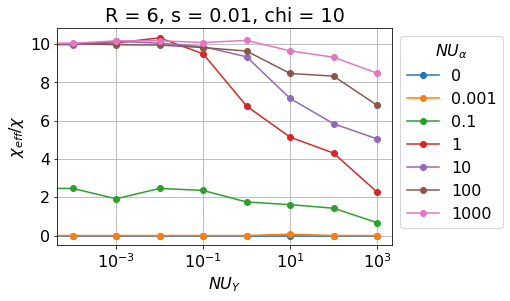

In [78]:
chi = 10
nu_alpha = [0, 0.001, 0.1, 1, 10, 100, 1000]

for NU_alpha in nu_alpha: 
    
        CHI_EFF = []
        UY = []

        for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_*_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_alpha, chi)):
            temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
            temp = np.array(np.split(temp, n_simulations))

            chi_eff = effective_chi(temp)

            numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
            NU_Y_file = float(numbers[7])

            CHI_EFF.append(chi_eff)# / chi)
            UY.append(NU_Y_file)

        UY, CHI_EFF = list(zip(*sorted(zip(UY, CHI_EFF)))) # sort the two list based on U_Y
        plt.plot(UY, CHI_EFF, 'o-', label = NU_alpha)

plt.xscale('log')
plt.title('R = {}, s = {}, chi = {}'.format(R, s, chi))
plt.xlabel(r'$NU_Y$')
plt.ylabel(r'$\chi_{eff} / \chi$')
plt.grid()
plt.legend(title = r'$NU_\alpha$', bbox_to_anchor = (1,1), loc = 0)

plt.show()

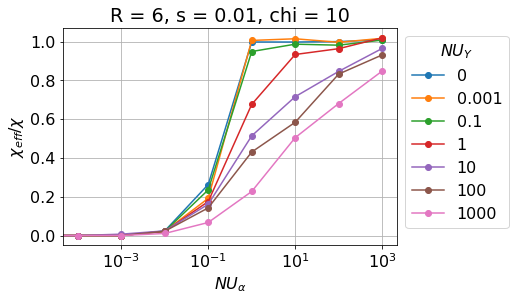

In [73]:
chi = 10
nu_y = [0, 0.001, 0.1, 1, 10, 100, 1000]

for NU_Y in nu_y: 
    
        CHI_EFF = []
        UALPHA = []

        for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_*_{:0.1e}.txt".format(R, eps, s, NU_Y, chi)):

            temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
            temp = np.array(np.split(temp, n_simulations))

            chi_eff = effective_chi(temp)

            numbers = re.findall("\d+\.\d+e[+\-]\d+", filename) # read the parameters in the name of the file
            NU_alpha_file = float(numbers[8])

            CHI_EFF.append(chi_eff / chi)
            UALPHA.append(NU_alpha_file)

        UALPHA, CHI_EFF = list(zip(*sorted(zip(UALPHA, CHI_EFF)))) # sort the two list based on U_Y
        plt.plot(UALPHA, CHI_EFF, 'o-', label = NU_Y)

plt.xscale('log')
plt.title('R = {}, s = {}, chi = {}'.format(R, s, chi))
plt.xlabel(r'$NU_\alpha$')
plt.ylabel(r'$\chi_{eff} / \chi$')
plt.grid()
plt.legend(title = r'$NU_Y$', bbox_to_anchor = (1,1), loc = 0)

plt.show()

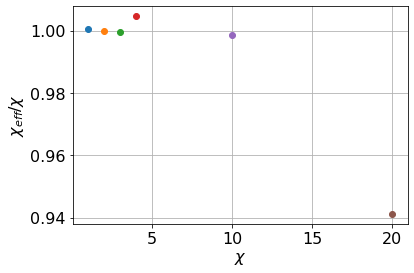

In [19]:
for (i, chi) in enumerate(CHI):
    
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, s, 0, NU_alpha, chi)):
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))

        chi_eff = effective_chi(temp)

        plt.plot(chi, chi_eff / chi, 'o')

        
x = np.linspace(0,20,100)

#plt.plot(x, np.exp(-x**2 / 8**2))
        
#plt.title('s = {}, NU_Y = {}, NU_alpha = {}'.format(s, 0, NU_alpha))
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\chi_{eff} / \chi$')
plt.grid()

plt.show()

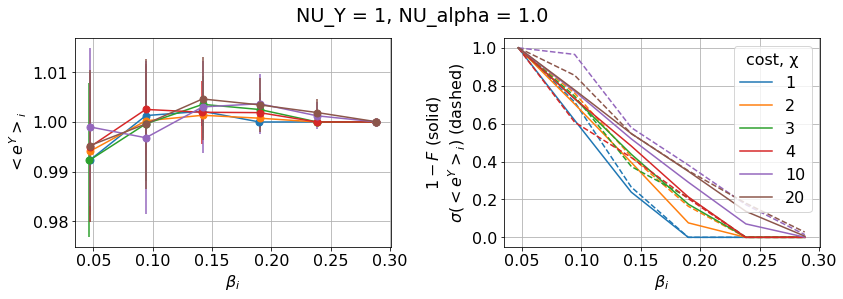

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

for (i, chi) in enumerate(CHI):
    for filename in glob.glob("./Data/run_{:0.1e}_*_*_*_*_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}_{:0.1e}.txt".format(R, eps, s, NU_Y, NU_alpha, chi)):
        
        temp = pd.read_csv(filename, delimiter = ',', names = list(range(R))).to_numpy()
        temp = np.array(np.split(temp, n_simulations))
        
        for j in range(n_simulations):
            temp[j][1] /= temp[j][9][0]

        beta = temp[:, 0].mean(axis = 0)
        eY = temp[:, 1].mean(axis = 0)
        err_eY = temp[:, 1].std(axis = 0)
        F = temp[:, 3].mean(axis = 0)
        
        # plots
        ax[0].errorbar(beta, eY, yerr = err_eY, fmt = 'o-', markersize = 7)        
        if (chi != 0 and NU_Y != 0):
            ax[1].plot(beta, (1 - F) / max(1 - F), '-C' + str(i), label = chi)
            ax[1].plot(beta, err_eY / max(err_eY), '--C' + str(i))
        else:
            ax[1].plot(beta, (1 - F), '-C' + str(i), label = chi)
            ax[1].plot(beta, err_eY, '--C' + str(i))

plt.suptitle('NU_Y = {}, NU_alpha = {}'.format(NU_Y, NU_alpha), y = 1.05)
ax[0].set_xlabel(r'$\beta_i$')
ax[0].set_ylabel(r'$<e^Y>_i$')
ax[0].grid()

ax[1].set_xlabel(r'$\beta_i$')
ax[1].set_ylabel(r'$1-F$ (solid)' '\n' '$\sigma(<e^Y>_i)$ (dashed)')
ax[1].grid()

ax[1].legend(title = 'cost, χ', loc = 0)

plt.tight_layout()
plt.show()